# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
link = 'https://drive.google.com/open?id=1ANUjFD-iRBZuo1i15vgYmknoheh0rtkN'

In [3]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1ANUjFD-iRBZuo1i15vgYmknoheh0rtkN


In [4]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con1 = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')
#/content/drive/My Drive/Asgn/



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con1) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con1)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con1)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con1)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:31<00:00, 1721.78it/s]


In [26]:
preprocessed_reviews[3500]

'tried teas yet nice really love variety able try something new'

In [27]:
final.shape


(364171, 10)

In [0]:
final['cleanedText']=preprocessed_reviews

In [29]:
final.shape


(364171, 11)

In [30]:
final.shape


(364171, 11)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [29]:
#Taking random 60000 ponits

final_data = final.sample(n=90000)

final_data.shape

(90000, 11)

In [30]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final_df = final_data.sort_values(by = "Time")
print(final.shape)
final_df.head(5)

(364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanedText
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,2000-06-03,Research,I'm getting crazy.<p>Is it really impossible t...,getting crazy really impossible today not find...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,getting crazy looking beatlejuice french versi...


In [31]:
# 80k data which will use to train model after vectorization
X = final_df['cleanedText']
print("shape of X:", X.shape)
# class label
Y = final_df["Score"]
print("shape of Y:", Y.shape)

shape of X: (90000,)
shape of Y: (90000,)


In [0]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33) # this is random splitting


print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(40401,) (40401,)
(19899,) (19899,)
(29700,) (29700,)


# [4] Featurization

# [5.1.1] Applying Logistic Regression with L1 regularization on BOW, SET 1

In [34]:
# Training to Bow Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_bowtr = bow.fit_transform(X_train)
X_bowtr

<40401x38960 sparse matrix of type '<class 'numpy.int64'>'
	with 1327842 stored elements in Compressed Sparse Row format>

In [35]:
X_bowtr.shape

(40401, 38960)

In [36]:
# Test Vectorizor training
X_bowts = bow.transform(X_test)
X_bowts.shape

(29700, 38960)

In [37]:
# Test Vectorizor training
X_CVts = bow.transform(X_cv)
X_CVts.shape

(19899, 38960)

In [38]:
#Using CalibratedClassifierCV with cv=35
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clfb = LogisticRegression(C= 35, penalty= 'l1')
clfb.fit(X_bowtr,Y_train)

m = CalibratedClassifierCV(clfb ,  cv=5, method='sigmoid')
m.fit(X_bowtr, Y_train)
prob_pos_sigm = m.predict_proba(X_bowts)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ", m.get_params)





0.9999999824389645
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=35, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=5, method='sigmoid')>


In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test,m.predict(X_bowts))*100))

Accuracy on test set: 90.121%


In [40]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_cv,m.predict(X_CVts))*100))

Accuracy on test set: 90.165%


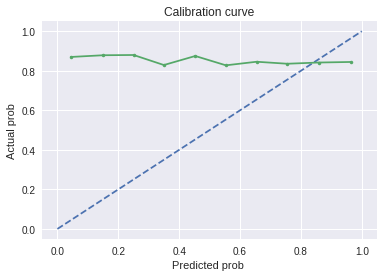

In [126]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = m.predict_proba(X_bowts)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()


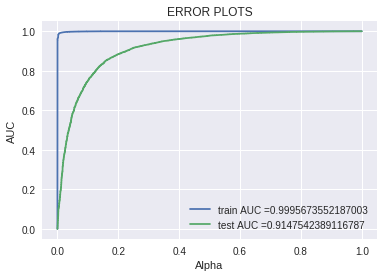

Train confusion matrix
[[ 3392  2916]
 [    0 34093]]
Test confusion matrix
[[ 2177  2456]
 [  478 24589]]


In [42]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m.predict_proba(X_bowtr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m.predict_proba(X_bowts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m.predict(X_bowtr)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m.predict(X_bowts)))

Test AUC score is 0.915 over train AUC 0.999.

In [43]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,m.predict(X_bowts))
cm

array([[ 2177,  2456],
       [  478, 24589]])

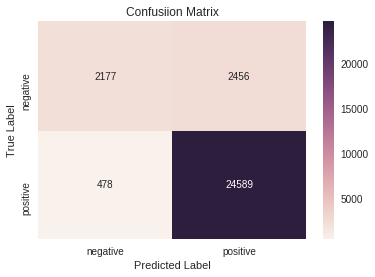

In [44]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **[5.1.2] Applying Logistic Regression with L2 regularization on BOW, SET 1**

In [45]:
#Using CalibratedClassifierCV with cv=25
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf2 = LogisticRegression(C= 60, penalty= 'l2')
clf2.fit(X_bowtr,Y_train)

m2 = CalibratedClassifierCV(clf2 ,  cv=25, method='sigmoid')
m2.fit(X_bowtr, Y_train)
print("Best parameters: ", m2.get_params)


Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=60, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=25, method='sigmoid')>


In [46]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test,clf2.predict(X_bowts))*100))

Accuracy on test set: 89.569%


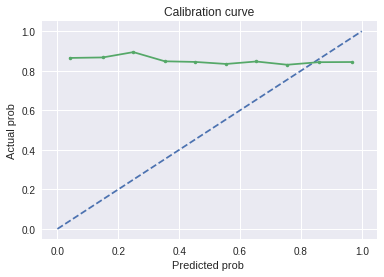

In [125]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = m2.predict_proba(X_bowts)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()

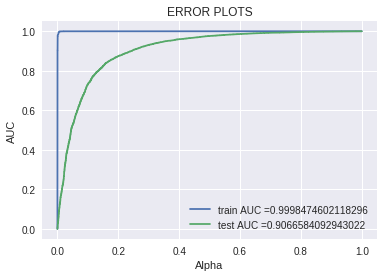

Train confusion matrix
[[ 4453  1855]
 [    0 34093]]
Test confusion matrix
[[ 2298  2335]
 [  593 24474]]


In [49]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m2.predict_proba(X_bowtr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m2.predict_proba(X_bowts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m2.predict(X_bowtr)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m2.predict(X_bowts)))

AUC score for Test is 0.904.

In [50]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(Y_test,m2.predict(X_bowts))
cm2

array([[ 2298,  2335],
       [  593, 24474]])

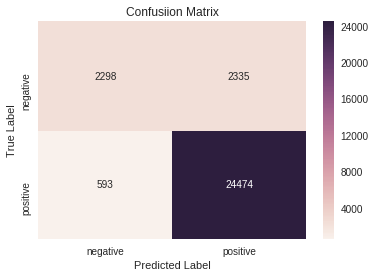

In [51]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm2, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [53]:
X_bowtr.shape

(40401, 39063)

In [0]:
#X_bowtr['zeros']= N
#Xnew = np.hstack((N,X_bowtr))

In [0]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from statsmodels.tools.tools import add_constant


In [0]:
#From https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
#from statsmodels.stats.outliers_influence import variance_inflation_factor 
#from statsmodels.tools.tools import add_constant

#def calculate_vif_(Xnew, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param X: the pandas dataframe
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    #const = add_constant(Xnew)
    #cols = const.columns
    #variables = np.arange(const.shape[1])
   # vif_df = pd.Series([variance_inflation_factor(const.values, i) 
               #for i in range(const.shape[1])], 
              #index=const.columns).to_frame()

    #vif_df = vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    #vif_df = vif_df.drop('const')
    #vif_df = vif_df[vif_df['VIF'] > thresh]

    #print ('Features above VIF threshold:\n')
   # print (vif_df[vif_df['VIF'] > thresh])

In [0]:
#calculate_vif_(Xnew)

# [5.1.2.1]** Performing pertubation test (multicollinearity check) on BOW, SET 1

In [0]:
from scipy.sparse import find
#Weights before adding random noise
w1 = clf2.coef_
print(w1[:20])
print(w1.size)

[[4.41540509e-02 1.22133274e-03 2.70087099e-04 ... 1.26664144e-05
  1.32880715e-05 1.20821162e-03]]
36982


In [0]:
#Adding noise to do pertubation of the data, to check the collinearity and multicollinearity in data to check whether we can use weight in Logistic Regression or not
#https://datascience.stackexchange.com/questions/37000/how-to-add-noise-to-supervised-binary-classifier


#dimesions = data #to get the dimesion of the data
#noise = np.random.rand(dimesion)
#noisy_data = data + noise # to add noise the existing data 

from scipy.sparse import *
from sklearn.datasets import *

random_data = X_bowtr

#Random noise
#https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.random.uniform.html
e = np.random.uniform(low=-0.0001, high=0.0001, size=(find(random_data)[0].size,))

#Return the indices and values of the nonzero elements of a matrix
a,b,c = find(random_data)

#Introducing random noise to train dataset
random_data[a,b] = e + random_data[a,b]

In [0]:
random_data.shape

(35912, 36982)

In [0]:
random_data[a,b].shape

(1, 1184949)

In [0]:
#Fitting after adding error to original data
from sklearn.metrics import accuracy_score
clfe = LogisticRegression(C= 50, penalty= 'l2')
clfe.fit(random_data,Y_train)
Y_pre = clfe.predict(X_bowts)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pre)*100))

print("Non Zero weights:",np.count_nonzero(clfe.coef_))

Accuracy on test set: 90.110%
Non Zero weights: 27349


In [0]:
from scipy.sparse import find
#Weights after adding random noise
w2 = clfe.coef_
print(w2[:20])
print(w2.size)

[[1.08242842 0.         0.00717928 ... 0.00134299 0.         0.0932569 ]]
36982


In [0]:
#Finding absolute difference
wd = abs((w1 - w2)/w1) * 100
wd

array([[2297.19006437,  100.        ,  465.25911676, ...,   32.61897411,
         100.        , 4123.18675028]])

In [0]:
print(wd[np.where(wd > 50)].size)

30832


In [0]:
#adding a small to weights
w1=w1+0.001
w2=w2+0.001
print(w1.shape , w2.shape)

(1, 36982) (1, 36982)


In [0]:
#Calculating percentage
per_chang=(abs(w1 - w2)/w1) * 100
per_chang

array([[2247.41783379,   68.95694789,  260.30701732, ...,   16.41212837,
          50.33000919, 2837.98887697]])

In [0]:
#Change for range of 0 to 100
r=np.arange(0,100,10)
P1 = np.percentile(per_chang,r )
P1

array([-4.18816252e+06, -1.03687471e+02, -3.79173573e+01,  2.06814524e+01,
        4.99741941e+01,  5.60943027e+01,  8.56209482e+01,  9.98212057e+01,
        2.64223789e+02,  1.56131682e+03])

In [0]:
#Change for range of 99 to 100
r1=np.arange(99.1,100,10)
P2 = np.percentile(per_chang,r )
P2

array([-4.18816252e+06, -1.03687471e+02, -3.79173573e+01,  2.06814524e+01,
        4.99741941e+01,  5.60943027e+01,  8.56209482e+01,  9.98212057e+01,
        2.64223789e+02,  1.56131682e+03])

In [0]:
print("No of features",wd[np.where(wd>45)].size)
  

No of features 31358


In [0]:
#Getting features
features = bow.get_feature_names()

In [0]:
#Using argsort to sort in order
Sort=per_chang.argsort()
k=Sort[0][-15:]
print(b)
array=[]
for i in k:
  array.append(features[i])
print("Top collinear features",array)

[29219 29831  3389 12114  7240 12050  1276 32846 16703 36235  1801 32545
 23734 31666 16294]
Top collinear features ['nigh', 'unnamed', 'sludgy', 'incremental', 'artificail', 'dusts', 'sorting', 'felines', 'delayed', 'worchestershire', 'educating', 'rouge', 'vienne', 'lethargy', 'supppose']


## [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW, SET **1**

In [0]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

import numpy as np

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_bowtr, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

500


In [0]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

import numpy as np

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(X_bowtr, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

47


In [0]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

import numpy as np

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(X_bowtr, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

1


# **[5.1.3] Feature Importance on BOW, SET 1

In [0]:
features = bow.get_feature_names()

In [0]:
# Taken from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def informative_features(bow, clfl2, n= 10):
    feature_names = features
    coefs_with_fns = sorted(zip(clfl2.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))

In [0]:

informative_features(X_bowtr,clfb)

		Positive					Negative
_________________________________________________________________________________ 

	20.9632	easiest        				-18.4795	intelligensia  
	19.4423	basics         				-16.1921	akmak          
	18.9696	ouches         				-15.1593	fusili         
	18.4974	nuked          				-13.8958	doctored       
	18.4689	pinto          				-13.8146	renbur         
	14.4623	straightforward				-12.4296	recourse       
	14.3259	ridder         				-11.8417	represents     
	13.0659	monster        				-11.6669	filmy          
	12.1875	downside       				-11.1082	dh             
	11.9827	addiction      				-10.7242	groupon        


In [0]:
### Used code from https://blancas.io/sklearn-evaluation/api/plot.html
from sklearn.metrics import classification_report
y_true, y_pred = Y_test, clfb.predict(X_bowts)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      4101
           1       0.94      0.93      0.94     22299

   micro avg       0.89      0.89      0.89     26400
   macro avg       0.80      0.80      0.80     26400
weighted avg       0.89      0.89      0.89     26400



## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [52]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting



print(X_train.shape, Y_train.shape)

print(X_test.shape, Y_test.shape)

(60300,) (60300,)
(29700,) (29700,)


In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [55]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15007
sample words  ['bought', 'cow', 'ears', 'labrador', 'retriever', 'lower', 'calorie', 'fat', 'alternative', 'compared', 'pig', 'dog', 'loves', 'larger', 'others', 'not', 'huge', 'majority', 'good', 'sized', 'may', 'big', 'ones', 'get', 'pet', 'store', 'pay', 'think', 'price', 'excellent', 'looking', 'change', 'teas', 'must', 'say', 'welcomed', 'hot', 'cocoa', 'fan', 'husband', 'new', 'orleans', 'community', 'coffee', 'choice', 'louisiana', 'locals', 'rich', 'without', 'bitter']


In [56]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(len(sent_vectors_tr[0]))

100%|██████████| 60300/60300 [03:49<00:00, 532.50it/s]

60300


In [0]:
from sklearn import preprocessing
Xavg=preprocessing.normalize(sent_vectors_tr)

In [58]:
print(Xavg.shape)

(60300, 50)


In [0]:
# Training for Xtrain
i=0
list_of_sent_ts=[]
for sent in X_test.values:
   list_of_sent_ts.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_ts=Word2Vec(list_of_sent_ts,min_count=5,size=50, workers=4)

In [61]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15007
sample words  ['bought', 'cow', 'ears', 'labrador', 'retriever', 'lower', 'calorie', 'fat', 'alternative', 'compared', 'pig', 'dog', 'loves', 'larger', 'others', 'not', 'huge', 'majority', 'good', 'sized', 'may', 'big', 'ones', 'get', 'pet', 'store', 'pay', 'think', 'price', 'excellent', 'looking', 'change', 'teas', 'must', 'say', 'welcomed', 'hot', 'cocoa', 'fan', 'husband', 'new', 'orleans', 'community', 'coffee', 'choice', 'louisiana', 'locals', 'rich', 'without', 'bitter']


In [62]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_ts): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 29700/29700 [00:57<00:00, 513.11it/s]

29700
50


In [0]:
#Xtsavg=sent_vectors_ts
Xtsavg = preprocessing.normalize(sent_vectors)

In [64]:
print(Xtsavg.shape)

(29700, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# Training for Xtrain
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [67]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15007
sample words  ['bought', 'cow', 'ears', 'labrador', 'retriever', 'lower', 'calorie', 'fat', 'alternative', 'compared', 'pig', 'dog', 'loves', 'larger', 'others', 'not', 'huge', 'majority', 'good', 'sized', 'may', 'big', 'ones', 'get', 'pet', 'store', 'pay', 'think', 'price', 'excellent', 'looking', 'change', 'teas', 'must', 'say', 'welcomed', 'hot', 'cocoa', 'fan', 'husband', 'new', 'orleans', 'community', 'coffee', 'choice', 'louisiana', 'locals', 'rich', 'without', 'bitter']


In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [69]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60300/60300 [28:40<00:00, 35.06it/s]


In [0]:
from sklearn import preprocessing
xtfidf = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

In [0]:
# Training for Xtest
i=0
list_of_sent_ts=[]
for sent in X_test.values:
   list_of_sent_ts.append(sent.split())

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_ts=Word2Vec(list_of_sent_ts,min_count=5,size=50, workers=4)

In [73]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15007
sample words  ['bought', 'cow', 'ears', 'labrador', 'retriever', 'lower', 'calorie', 'fat', 'alternative', 'compared', 'pig', 'dog', 'loves', 'larger', 'others', 'not', 'huge', 'majority', 'good', 'sized', 'may', 'big', 'ones', 'get', 'pet', 'store', 'pay', 'think', 'price', 'excellent', 'looking', 'change', 'teas', 'must', 'say', 'welcomed', 'hot', 'cocoa', 'fan', 'husband', 'new', 'orleans', 'community', 'coffee', 'choice', 'louisiana', 'locals', 'rich', 'without', 'bitter']


In [74]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_ts): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsts.append(sent_vec)
    row += 1

100%|██████████| 29700/29700 [14:03<00:00, 35.17it/s]


In [0]:
xtstfidf = preprocessing.normalize(tfidf_sent_vectorsts)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [76]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_tftr = tf_idf_vect.fit_transform(X_train)
X_tftr.shape

(60300, 1089121)

In [77]:
# Convert test text data to its vectorizor
X_tfts = tf_idf_vect.transform(X_test)
X_tfts.shape

(29700, 1089121)

In [78]:
# Convert test text data to its vectorizor
X_tfcv = tf_idf_vect.transform(X_cv)
X_tfcv.shape

(19899, 1089121)

In [79]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf3 = LogisticRegression(C= 10, penalty= 'l1')
clf3.fit(X_tftr,Y_train)

m3 = CalibratedClassifierCV(clf3 ,  cv=5, method='sigmoid')
m3.fit(X_tftr, Y_train)
prob_pos_sigm = m3.predict_proba(X_tfts)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ", m3.get_params)





0.9997069008197059
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=5, method='sigmoid')>


In [80]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, clf3.predict(X_tfts))*100))

Accuracy on test set: 93.061%


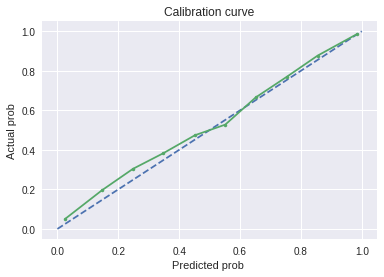

In [119]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = m3.predict_proba(X_tfts)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

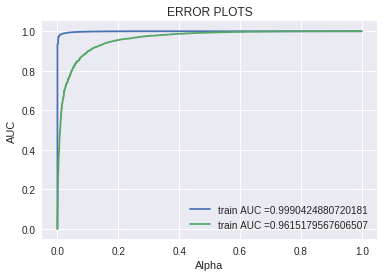

Train confusion matrix
[[ 8648   817]
 [  126 50709]]
Test confusion matrix
[[ 3408  1199]
 [  784 24309]]


In [82]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m3.predict_proba(X_tftr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m3.predict_proba(X_tfts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m3.predict(X_tftr)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m3.predict(X_tfts)))

Test AUC is 0.958

In [83]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(Y_test,m3.predict(X_tfts))
cm3

array([[ 3408,  1199],
       [  784, 24309]])

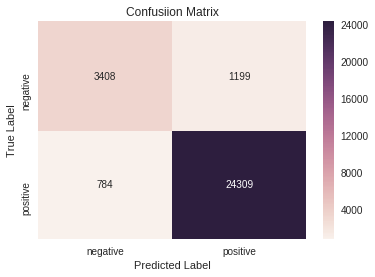

In [84]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm3, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [85]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf4 = LogisticRegression(C= 10, penalty= 'l2')
clf4.fit(X_tftr,Y_train)

m4 = CalibratedClassifierCV(clf4 ,  cv=5, method='sigmoid')
m4.fit(X_tftr, Y_train)
prob_pos_sigm = m4.predict_proba(X_tfts)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ", m4.get_params)



0.9950452526915005
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=5, method='sigmoid')>


In [86]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, m4.predict(X_tfts))*100))

Accuracy on test set: 93.508%


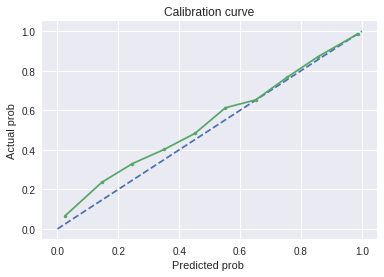

In [118]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs = m4.predict_proba(X_tfts)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()

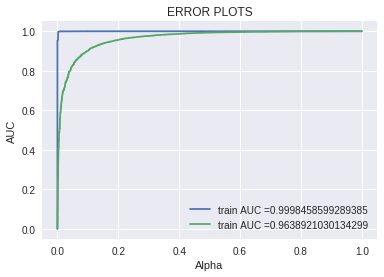

Train confusion matrix
[[ 9429    36]
 [   97 50738]]
Test confusion matrix
[[ 3516  1091]
 [  837 24256]]


In [88]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m4.predict_proba(X_tftr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m4.predict_proba(X_tfts)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m4.predict(X_tftr)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m4.predict(X_tfts)))

Auc score for test set is near to Train AUC improved model training.

In [89]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(Y_test,m4.predict(X_tfts))
cm4

array([[ 3516,  1091],
       [  837, 24256]])

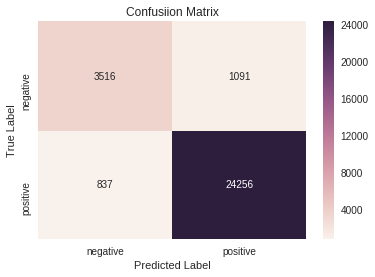

In [90]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm4, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [0]:
feat = tf_idf_vect.get_feature_names()

In [0]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def show_most_informative_features(tf_idf_vect, clf4, n= 10):
    feature_names = feat
    coefs_with_fns = sorted(zip(clf4.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))

In [93]:
show_most_informative_features(tf_idf_vect, clf4)

		Positive					Negative
_________________________________________________________________________________ 

	22.2916	great          				-16.7640	disappointed   
	16.8111	delicious      				-14.6569	worst          
	16.4957	best           				-13.7557	awful          
	14.7796	perfect        				-13.6748	not worth      
	14.2071	good           				-13.3984	disappointing  
	12.8695	love           				-13.3439	terrible       
	12.6072	loves          				-13.2498	not            
	12.4443	excellent      				-13.1705	not recommend  
	12.4157	wonderful      				-11.7275	disappointment 
	11.2895	not disappointed				-11.2892	not good       


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [94]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf5 = LogisticRegression(C= 50, penalty= 'l1')
clf5.fit(Xavg,Y_train)

m5= CalibratedClassifierCV(clf5,  cv=25, method='sigmoid')
m5.fit(Xavg, Y_train)
prob_pos_sigm = m5.predict_proba(Xtsavg)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ",  m5.get_params)





0.9012701518746694
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=25, method='sigmoid')>


In [95]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test,clf5.predict(Xtsavg))*100))

Accuracy on test set: 89.293%


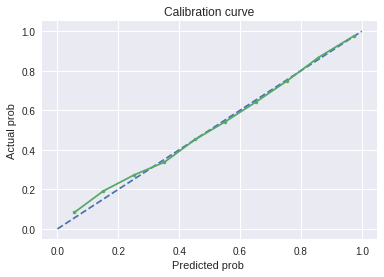

[0.99527653 0.99485349 0.48081203 ... 0.91172653 0.93646202 0.90819177]


In [120]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs1 = clf5.predict_proba(Xtsavg)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs1, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()
print(probs1)


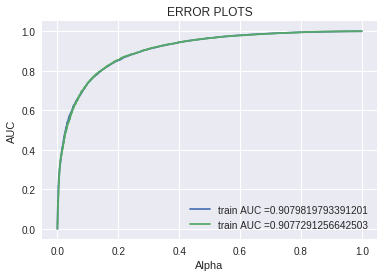

Train confusion matrix
[[ 4759  4706]
 [ 1783 49052]]
Test confusion matrix
[[ 2332  2275]
 [  901 24192]]


In [97]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m5.predict_proba(Xavg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m5.predict_proba(Xtsavg)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m5.predict(Xavg)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m5.predict(Xtsavg)))

Test AUC score is pimprovised over training.

In [98]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm5 = confusion_matrix(Y_test,m5.predict(Xtsavg))
cm5

array([[ 2332,  2275],
       [  901, 24192]])

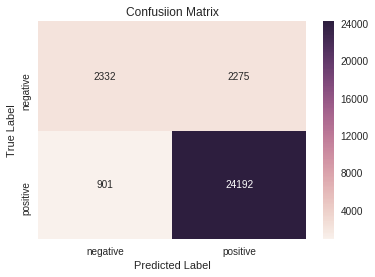

In [99]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm5, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [100]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf6 = LogisticRegression(C= 75, penalty= 'l2')
clf6.fit(Xavg,Y_train)

m6 = CalibratedClassifierCV(clf6 ,  cv=50, method='sigmoid')
m6.fit(Xavg, Y_train)
prob_pos_sigm = m6.predict_proba(Xtsavg)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ", m6.get_params)





0.9005254640752572
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=75, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=50, method='sigmoid')>


In [101]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test,clf6.predict(Xtsavg))*100))

Accuracy on test set: 89.293%


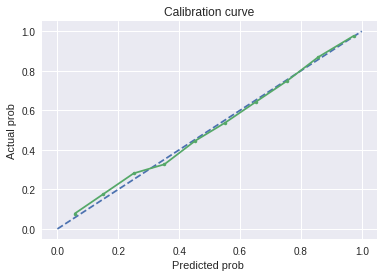

[0.99933527 0.9978416  0.86819428 ... 0.98761015 0.2234879  0.97166158]


In [121]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = m6.predict_proba(Xtsavg)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()
print(probs)

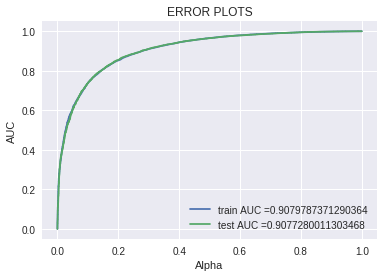

Train confusion matrix
[[ 4742  4723]
 [ 1770 49065]]
Test confusion matrix
[[ 2325  2282]
 [  891 24202]]


In [103]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m6.predict_proba(Xavg)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m6.predict_proba(Xtsavg)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m6.predict(Xavg)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m6.predict(Xtsavg)))

Test AUC is improved with model training.

In [104]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm6 = confusion_matrix(Y_test,m6.predict(Xtsavg))
cm6

array([[ 2325,  2282],
       [  891, 24202]])

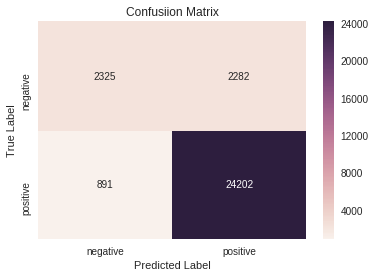

In [105]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm6, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [106]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf7 = LogisticRegression(C= 150, penalty= 'l1')
clf7.fit(xtfidf,Y_train)

m7 = CalibratedClassifierCV(clf7 ,  cv=25, method='sigmoid')
m7.fit(xtfidf,Y_train)
prob_pos_sigm = m7.predict_proba(xtstfidf)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ", m7.get_params)


0.8922679174158467
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=150, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=25, method='sigmoid')>


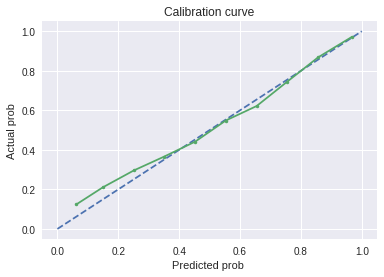

In [123]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = m7.predict_proba(xtstfidf)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()


In [107]:
from sklearn.metrics import accuracy_score
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, m7.predict(xtstfidf))*100))

Accuracy on test set: 87.771%


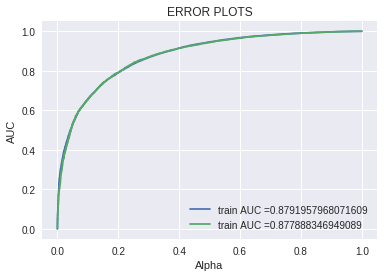

Train confusion matrix
[[ 3771  5694]
 [ 1638 49197]]
Test confusion matrix
[[ 1804  2803]
 [  829 24264]]


In [108]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m7.predict_proba(xtfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m7.predict_proba(xtstfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m7.predict(xtfidf)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m7.predict(xtstfidf)))

Test AUC is nearer to Train AUC score.

In [109]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm7 = confusion_matrix(Y_test,m7.predict(xtstfidf))
cm7

array([[ 1804,  2803],
       [  829, 24264]])

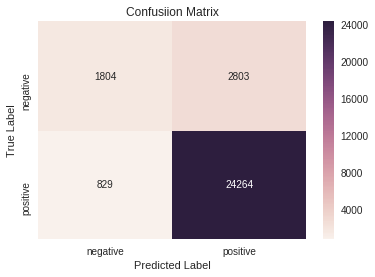

In [110]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm7, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [111]:
#Using CalibratedClassifierCV with cv=5
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
clf = LogisticRegression(C= 20, penalty= 'l2')
clf.fit(xtfidf,Y_train)

m8 = CalibratedClassifierCV(clf ,  cv=250, method='sigmoid')
m8.fit(xtfidf,Y_train)
prob_pos_sigm = m8.predict_proba(xtstfidf)[2:, 1]
print(prob_pos_sigm[1])

print("Best parameters: ", m8.get_params)


0.8879020578580783
Best parameters:  <bound method BaseEstimator.get_params of CalibratedClassifierCV(base_estimator=LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            cv=250, method='sigmoid')>


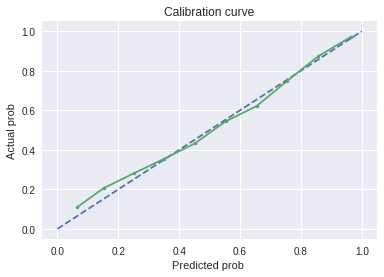

In [124]:
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# predict probabilities
probs2 = m8.predict_proba(xtstfidf)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(Y_test, probs2, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.title("Calibration curve")
plt.xlabel('Predicted prob ')
plt.ylabel('Actual prob')
pyplot.show()


In [112]:
from sklearn.metrics import accuracy_score
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, m8.predict(xtstfidf))*100))

Accuracy on test set: 87.801%


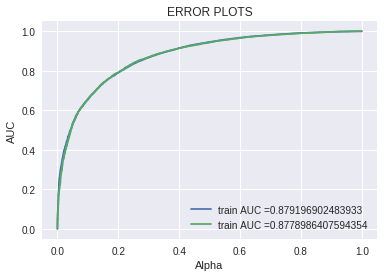

Train confusion matrix
[[ 3666  5799]
 [ 1549 49286]]
Test confusion matrix
[[ 1765  2842]
 [  781 24312]]


In [113]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, m8.predict_proba(xtfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, m8.predict_proba(xtstfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, m8.predict(xtfidf)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, m8.predict(xtstfidf)))

AUC score is close to training AUC

In [114]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm8 = confusion_matrix(Y_test,m8.predict(xtstfidf))
cm8

array([[ 1765,  2842],
       [  781, 24312]])

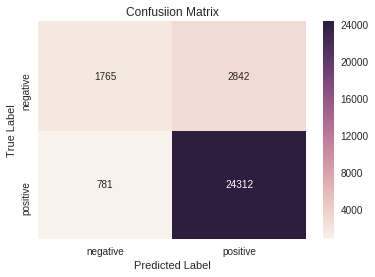

In [115]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm8, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [127]:
#pretty table

from prettytable import PrettyTable
    
p = PrettyTable()

p.field_names = ["Vectoriser model","Regularisation" , "AUC", ]

p.add_row(["BOW", "L1", 0.91,] )
p.add_row(["BOW", "L2", 0.90,] )
p.add_row(["TFIDF","L1" , 0.95,])
p.add_row(["TFIDF","L2",  0.96,])
p.add_row(["Avg Word2vec","L1" , 0.90,] )
p.add_row(["Avg Word2vec","L2",  0.90,] )
p.add_row(["Avg TFIDFW2vec","L1" , 0.87,] )
p.add_row(["Avg TFIDFW2vec","L2",  0.88,] )
print(p)

+------------------+----------------+------+
| Vectoriser model | Regularisation | AUC  |
+------------------+----------------+------+
|       BOW        |       L1       | 0.91 |
|       BOW        |       L2       | 0.9  |
|      TFIDF       |       L1       | 0.95 |
|      TFIDF       |       L2       | 0.96 |
|   Avg Word2vec   |       L1       | 0.9  |
|   Avg Word2vec   |       L2       | 0.9  |
|  Avg TFIDFW2vec  |       L1       | 0.87 |
|  Avg TFIDFW2vec  |       L2       | 0.88 |
+------------------+----------------+------+


Observations

*   Trained models for all vectorisers.
*  AUC curves are plotted for all the models.
*  Performance is improved with more number of validations.
*  Confusiom matrix is  printed .
* Accuracy is increasewd with L2 regularisation in most of the models.
*  Results are represented in Pretty table.
* Calibration curve is provided for all models.


